In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio.plot

## Handler

In [2]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point

# precision of input coordinates, 5 decimals is about 1.1m of a commercial 'correcting' GPS unit
# this post is helpful: https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude
precision = 5

class GISHandler:
    def __init__(self, files):
        self.rasters = {}
        self.points = gpd.GeoDataFrame(columns=['x', 'y', 'result', 'geometry'], geometry='geometry')
        
        for key, src in files.items():
            if key in self.rasters:
                print('raster {} already loaded!'.format(key))
            else:
                self.rasters[key] = rasterio.open(src)
    
    def query(self, x, y):
        x, y = self.clean(x, y)
                                    
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            print('point exists, returning original data')
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'geometry': Point(x, y)}
        
        for key, raster in self.rasters.items():
            index = raster.index(x, y)
            try:
                 conditions[key] = raster.read(1)[index] # yes, by default this only reads the first band, but this is probably okay
            except IndexError as error:
                print('failed to read {} raster: {}'.format(key, error))    
        
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]
    
    def record(self, x, y, value):
        x, y = self.clean(x, y)
        
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            self.points.loc[(self.points.x==x) & (self.points.y==y), 'result'] = value
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'geometry': Point(x, y), 'result': value}
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]       
        
    def clean(self, x, y):
        return round(x, precision), round(y, precision)

## Example

In [3]:
raster_files = {'oxygen': 'data/surface-oxygen-mgpl-4326.tif'}
handler = GISHandler(raster_files)

In [10]:
handler.points

,x,y,result,geometry,oxygen
0,-70,41,NaN,POINT (-70.00000 41.00000),9.332181
1,-70,40,43,POINT (-70.00000 40.00000),NaN


In [5]:
handler.query(-70, 41)

,x,y,result,geometry,oxygen
0,-70,41,NaN,POINT (-70.00000 41.00000),9.332181


In [6]:
handler.record(-70, 40, 43)

,x,y,result,geometry,oxygen
1,-70,40,43,POINT (-70.00000 40.00000),NaN


<AxesSubplot:>

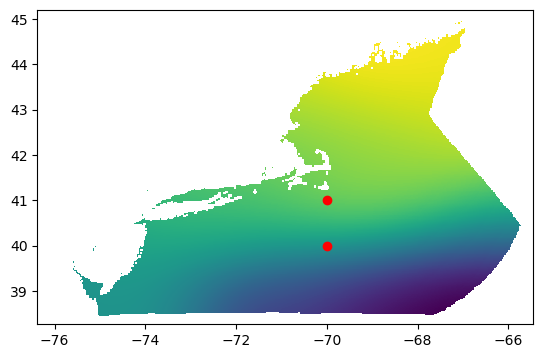

In [9]:
fig, ax = plt.subplots()
rasterio.plot.show(handler.rasters['oxygen'], ax=ax)
handler.points.plot(ax=ax, color='red')